In [3]:
from main import *

In [4]:
sigma = 0.5
k = 500
min = 50

In [5]:
input_path = "data/VOC2012_test/JPEGImages/2008_000017.jpg"

Height:  375
Width:   500
Execution time: 0 minute(s) and 13 seconds


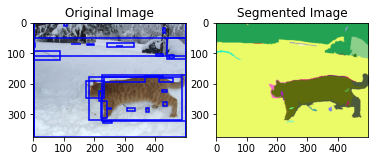

In [6]:
univ, output = segment(input_path, sigma, k, min)